<a href="https://colab.research.google.com/github/AnirudhDesai777/EEG_Emotion_Classification/blob/main/Copy_of_Copy_of_dwt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
pip install git+https://github.com/forrestbao/pyeeg.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/forrestbao/pyeeg.git to /tmp/pip-req-build-8568x6gg
  Running command git clone -q https://github.com/forrestbao/pyeeg.git /tmp/pip-req-build-8568x6gg
  Created wheel for pyeeg: filename=pyeeg-0.4.4-py2.py3-none-any.whl size=28131 sha256=e486b146e1eec0a88e0409c44b98a197c8636b43c8922113a7a6c28bbf6dac5c
  Stored in directory: /tmp/pip-ephem-wheel-cache-nik16b5k/wheels/b0/23/e4/703c908bda656959957029fa145879aa79307b2545a2ef0271
Successfully built pyeeg


In [ ]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 11.5,8.5

In [ ]:
from sklearn import metrics 
import seaborn as sns

In [ ]:
import numpy as np
import pickle as pickle
import pandas as pd
import pyeeg as pe
import pywt
from scipy.signal import hilbert
from sklearn.preprocessing import normalize

**DISCRETE WAVELET TRANSFORM**

In [ ]:
pip install PyWavelets

In [ ]:
import pywt

In [ ]:
pywt.families()

['haar',
 'db',
 'sym',
 'coif',
 'bior',
 'rbio',
 'dmey',
 'gaus',
 'mexh',
 'morl',
 'cgau',
 'shan',
 'fbsp',
 'cmor']

[Wavelet Families](https:/www.mathworks.com/help/wavelet/gs/introduction-to-the-wavelet-families.html/)

In [ ]:
channel = [2,3,4,6,7,11,15,17,20,24,25,27,28,29] #14 Channels chosen to fit Emotiv Epoch+
band = [4,8,12,16,25,45] #5 bands
window_size = 512 #Averaging band power of 2 sec
step_size = 64 #Each 0.125 sec update once
sample_rate = 128 #Sampling rate of 128 Hz
# subjectList = ['01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20','21','22','']
#List of subjects

In [ ]:
subjectList = []
for i in range(1,33):
  if i<10:
    i = '0'+str(i)
  else:
    i = str(i)
  subjectList.append(i)

In [ ]:
from statistics import mean

In [ ]:
from scipy.stats import entropy

In [ ]:
pip install antropy

     |████████████████████████████████| 49 kB 2.6 MB/s 
  Created wheel for antropy: filename=antropy-0.1.4-py3-none-any.whl size=16159 sha256=f927e7c0a4698997de37e5132e112db62336e4b61388f3eec277c48442945e3f
  Stored in directory: /root/.cache/pip/wheels/d4/cc/6b/28fa7036bdabc6f1f92fd6a108ae259dbb48f107f676d6b491
Successfully built antropy


In [ ]:
import antropy as ant

In [ ]:
def DWT_Processing_min (sub, channel, band, window_size, step_size, sample_rate):
    '''
    arguments:  string subject
                list channel indice
                list band
                int window size for FFT
                int step size for FFT
                int sample rate for FFT
    return:     void
    '''
    meta = []
    with open('/content/drive/My Drive/data_preprocessed_python/s' + sub + '.dat', 'rb') as file:

        subject = pickle.load(file, encoding='latin1') #resolve the python 2 data problem by encoding : latin1

        for i in range (0,39):
            # loop over 0-39 trails
            data = subject["data"][i]
            labels = subject["labels"][i]
            start = 0;
            
            while start + window_size < data.shape[1]:
                meta_array = []
                meta_data = [] #meta vector for analysis
                for j in channel:
                    X = data[j][start : start + window_size] #Slice raw data over 2 sec, at interval of 0.125 sec
                
                    coeffs = pywt.wavedec(X, 'db4', level=5)
                    cA5, cD5, cD4, cD3, cD2, cD1 = coeffs
                    sub_bands=[]
                     
                    sub_bands.append(min(list(cA5)))
                    sub_bands.append(min(list(cD5)))
                    sub_bands.append(min(list(cD4)))
                    sub_bands.append(min(list(cD3)))
                    sub_bands.append(min(list(cD2)))
                   
                    
                    meta_data = meta_data + sub_bands

                meta_array.append(np.array(meta_data))
                meta_array.append(labels)
                
                meta.append(meta_array)   
                start = start + step_size
                
        meta = np.array(meta)
        
        np.save('out\s' + sub, meta, allow_pickle=True, fix_imports=True)

In [ ]:
for subjects in subjectList:
    DWT_Processing_min (subjects, channel, band, window_size, step_size, sample_rate)

/usr/local/lib/python3.7/dist-packages/pywt/_multilevel.py:45: UserWarning: Level value of 5 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


KeyboardInterrupt: ignored

In [ ]:
data_training = []
label_training = []
data_testing = []
label_testing = []
data_validation = []
label_validation = []

for subjects in subjectList:
  

    with open('/content/out\s' + subjects + '.npy', 'rb') as file:
        sub = np.load(file,allow_pickle=True)
       
        for i in range (0,sub.shape[0]):
            if i % 8 == 0 or i % 8== 0:
                data_testing.append(sub[i][0])
                label_testing.append(sub[i][1])
           
            else:
                
                data_training.append(sub[i][0])
                label_training.append(sub[i][1])

np.save('out\data_training', np.array(data_training), allow_pickle=True, fix_imports=True)
np.save('out\label_training', np.array(label_training), allow_pickle=True, fix_imports=True)
print("training dataset:", np.array(data_training).shape, np.array(label_training).shape)


np.save('out\data_testing', np.array(data_testing), allow_pickle=True, fix_imports=True)
np.save('out\label_testing', np.array(label_testing), allow_pickle=True, fix_imports=True)
print("testing dataset:", np.array(data_testing).shape, np.array(label_testing).shape)


training dataset: (50778, 70) (50778, 4)
testing dataset: (7254, 70) (7254, 4)


In [ ]:
data= []
label = []
for subjects in subjectList:
  

    with open('/content/out\s' + subjects + '.npy', 'rb') as file:
        sub = np.load(file,allow_pickle=True)
        for i in range (0,sub.shape[0]):
          data.append(sub[i][0])
          label.append(sub[i][1])
np.save('data', np.array(data), allow_pickle=True, fix_imports=True)
np.save('label', np.array(label), allow_pickle=True, fix_imports=True)

In [ ]:
df=pd.DataFrame(data=data)
df.to_csv("data.csv",index=False)

df1=pd.DataFrame(data=label)
df1.to_csv("label.csv",index=False)

In [ ]:
data1_min=pd.read_csv("/content/data.csv")
data1_min

MEAN

In [ ]:
def DWT_Processing_mean (sub, channel, band, window_size, step_size, sample_rate):
    '''
    arguments:  string subject
                list channel indice
                list band
                int window size for FFT
                int step size for FFT
                int sample rate for FFT
    return:     void
    '''
    meta = []
    with open('/content/drive/My Drive/data_preprocessed_python/s' + sub + '.dat', 'rb') as file:

        subject = pickle.load(file, encoding='latin1') #resolve the python 2 data problem by encoding : latin1

        for i in range (0,39):
            # loop over 0-39 trails
            data = subject["data"][i]
            labels = subject["labels"][i]
            start = 0;
            
            while start + window_size < data.shape[1]:
                meta_array = []
                meta_data = [] #meta vector for analysis
                for j in channel:
                    X = data[j][start : start + window_size] #Slice raw data over 2 sec, at interval of 0.125 sec
                
                    coeffs = pywt.wavedec(X, 'db4', level=5)
                    cA5, cD5, cD4, cD3, cD2, cD1 = coeffs
                    sub_bands=[]
                     
                    sub_bands.append(np.average(list(cA5)))
                    sub_bands.append(np.average(list(cD5)))
                    sub_bands.append(np.average(list(cD4)))
                    sub_bands.append(np.average(list(cD3)))
                    sub_bands.append(np.average(list(cD2)))
                   
                    
                    meta_data = meta_data + sub_bands

                meta_array.append(np.array(meta_data))
                meta_array.append(labels)
                
                meta.append(meta_array)   
                start = start + step_size
                
        meta = np.array(meta)
        
        np.save('out\s' + sub, meta, allow_pickle=True, fix_imports=True)
        

In [ ]:
for subjects in subjectList:
    DWT_Processing_mean (subjects, channel, band, window_size, step_size, sample_rate)

/usr/local/lib/python3.7/dist-packages/pywt/_multilevel.py:45: UserWarning: Level value of 5 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
data_training = []
label_training = []
data_testing = []
label_testing = []
data_validation = []
label_validation = []

for subjects in subjectList:
  

    with open('/content/out\s' + subjects + '.npy', 'rb') as file:
        sub = np.load(file,allow_pickle=True)
       
        for i in range (0,sub.shape[0]):
            if i % 8 == 0 or i % 8== 0:
                data_testing.append(sub[i][0])
                label_testing.append(sub[i][1])
           
            else:
                
                data_training.append(sub[i][0])
                label_training.append(sub[i][1])

np.save('out\data_training', np.array(data_training), allow_pickle=True, fix_imports=True)
np.save('out\label_training', np.array(label_training), allow_pickle=True, fix_imports=True)
print("training dataset:", np.array(data_training).shape, np.array(label_training).shape)


np.save('out\data_testing', np.array(data_testing), allow_pickle=True, fix_imports=True)
np.save('out\label_testing', np.array(label_testing), allow_pickle=True, fix_imports=True)
print("testing dataset:", np.array(data_testing).shape, np.array(label_testing).shape)
"""
np.save('out\data_validation', np.array(data_validation), allow_pickle=True, fix_imports=True)
np.save('out\label_validation', np.array(label_validation), allow_pickle=True, fix_imports=True)
print("validation dataset:", np.array(data_validation).shape, np.array(label_validation).shape)
"""

training dataset: (50778, 70) (50778, 4)
testing dataset: (7254, 70) (7254, 4)


'\nnp.save(\'out\\data_validation\', np.array(data_validation), allow_pickle=True, fix_imports=True)\nnp.save(\'out\\label_validation\', np.array(label_validation), allow_pickle=True, fix_imports=True)\nprint("validation dataset:", np.array(data_validation).shape, np.array(label_validation).shape)\n'

In [ ]:
data= []
label = []
for subjects in subjectList:
  

    with open('/content/out\s' + subjects + '.npy', 'rb') as file:
        sub = np.load(file,allow_pickle=True)
        for i in range (0,sub.shape[0]):
          data.append(sub[i][0])
          label.append(sub[i][1])
np.save('data', np.array(data), allow_pickle=True, fix_imports=True)
np.save('label', np.array(label), allow_pickle=True, fix_imports=True)

In [ ]:
df=pd.DataFrame(data=data)
df.to_csv("data.csv",index=False)

df1=pd.DataFrame(data=label)
df1.to_csv("label.csv",index=False)

In [ ]:
data1_mean=pd.read_csv("/content/data.csv")
data1_mean

,0,1,2,3,4,5,6,7,8,9,...,60,61,62,63,64,65,66,67,68,69
0,-0.480384,0.201322,1.052130,0.342719,0.651407,3.613345,-0.243051,1.351791,0.476817,0.300094,...,-2.611473,0.122565,-0.401618,-0.216980,-0.584636,-1.586772,-0.092489,0.231365,-0.140109,-0.329235
1,17.207471,0.974964,1.536506,-0.637192,0.860427,9.293240,1.001911,1.352479,-0.618336,0.292053,...,-9.270273,-0.719837,-0.909324,1.361100,-0.685040,-4.904668,-0.093091,-0.009875,0.690897,-0.239828
2,-11.524944,-0.122727,-0.144292,0.624432,0.681186,-2.911885,0.432407,-0.324202,0.422726,0.345282,...,7.423594,-0.163547,0.412384,-0.392398,-0.581896,3.926828,-1.043369,1.463155,-0.175745,-0.500734
3,-6.201523,-1.133518,1.387642,-0.330168,0.722720,-15.593674,-1.901422,0.251134,0.839755,0.402860,...,14.397670,1.949024,-0.799841,0.391568,-0.574932,12.318582,2.482330,0.425875,0.613153,-0.925171
4,-1.993622,1.004224,-0.182465,0.265551,0.519045,8.321129,1.533776,-0.206751,0.450545,0.154005,...,-6.345249,-1.501534,0.026964,0.967941,-0.228841,-3.155108,-1.791407,0.514677,1.209645,-0.439317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58027,-17.469092,-1.400848,-0.747766,0.685778,0.081285,4.675943,0.811389,-4.382633,-0.922071,-0.190700,...,-52.638902,-6.266785,6.417619,2.282704,-0.109200,37.128022,3.956973,0.256710,-1.451766,-0.215159
58028,8.455534,0.869826,-1.382293,0.550685,-0.050436,9.320977,-0.619055,-3.951285,-0.834423,-0.367375,...,-11.533899,3.563485,5.599681,-0.790057,-0.531721,-6.046037,-2.869387,0.082808,-0.790728,0.377132
58029,1.154905,-0.705139,-0.503339,0.047472,-0.042102,6.885760,1.670281,-4.948928,-0.571130,0.059944,...,-14.149000,-4.331922,5.532836,0.576135,-0.567385,-5.838153,2.427640,-2.789890,-0.801366,0.383452
58030,-7.928681,0.509869,-1.387988,0.441107,0.330306,-18.658358,-2.592860,-5.115580,0.463135,0.550175,...,24.642118,5.122710,6.303723,-0.744604,-1.219912,-4.549254,-3.173941,-1.592457,-0.861460,-0.182253


In [ ]:
label=pd.read_csv("/content/label.csv")
label

,0,1,2,3
0,7.71,7.60,6.90,7.83
1,7.71,7.60,6.90,7.83
2,7.71,7.60,6.90,7.83
3,7.71,7.60,6.90,7.83
4,7.71,7.60,6.90,7.83
...,...,...,...,...
58027,4.33,6.21,5.68,4.62
58028,4.33,6.21,5.68,4.62
58029,4.33,6.21,5.68,4.62
58030,4.33,6.21,5.68,4.62


In [ ]:
x=data1_mean.values

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x)
x = scaler.transform(x)

In [ ]:
# def one_hot_encoding(df):
#   emotions = []
#   for i in range(len(df)):
#     # emotion = ''
#     val = df.iloc[i,0]
#     aro = df.iloc[i,1]
#     if val >=5 and aro >=5:
#       emotion = 0 #'happy'
#     elif val >=5 and aro <5:
#       emotion = 1 #'anxious'
#     elif val <5 and aro <5:
#       emotion = 2 #'sad'
#     else:
#       emotion = 3 #'calm'
#     emotions.append(emotion)
#   df_emo = pd.DataFrame(emotions)
#   return df_emo

def one_hot_encoding(df):
  emotions = []
  for i in range(len(df)):
    # emotion = ''
    val = int(df.iloc[i,0])
    aro = int(df.iloc[i,1])
    if val in range(1,4) and aro in range(1,4):
      emotion = 0 #'depressed'
    elif val in range(4,7) and aro in range(1,4):
      emotion = 1 #'calm'
    elif val in range(7,10) and aro in range(1,4):
      emotion = 2 #'relaxed'
    elif val in range(1,4) and aro in range(4,7):
      emotion = 3 #'miserable'
    elif val in range(4,7) and aro in range(4,7):
      emotion = 4 #'neutral'
    elif val in range(7,10) and aro in range(4,7):
      emotion = 5 #'pleased'
    elif val in range(1,4) and aro in range(7,10):
      emotion = 6 #'distressed'
    elif val in range(4,7) and aro in range(7,10):
      emotion = 7 #'excited'
    elif val in range(7,10) and aro in range(7,10):
      emotion = 8 #'happy'

    emotions.append(emotion)
  df_emo = pd.DataFrame(emotions)
  return df_emo

In [ ]:
df_emo = one_hot_encoding(label)

AttributeError: ignored

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, df_emo.loc[:,0], test_size = 0.2, random_state = 4)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators = 100) 
clf.fit(x_train, y_train)

RandomForestClassifier()

In [ ]:
pred = clf.predict(x_test)

In [ ]:
from sklearn import metrics 
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, pred))

ACCURACY OF THE MODEL:  0.4475747393814078


In [ ]:
from sklearn.feature_selection import mutual_info_classif
mi = mutual_info_classif(x_train, y_train)

In [ ]:
mi

array([0.11047619, 0.12154411, 0.10671984, 0.09357775, 0.12954998,
       0.032119  , 0.03693942, 0.02750321, 0.0154518 , 0.02433039,
       0.07193485, 0.08634341, 0.06229482, 0.03658506, 0.04673498,
       0.0404481 , 0.05491296, 0.03940115, 0.02613072, 0.05461061,
       0.04359431, 0.04305626, 0.04001545, 0.06425111, 0.10447987,
       0.06306712, 0.07913707, 0.05964316, 0.03901783, 0.05749526,
       0.10470876, 0.11623535, 0.10086633, 0.07194523, 0.09894954,
       0.06536971, 0.07568546, 0.05373233, 0.02693743, 0.05218046,
       0.09365861, 0.11607574, 0.09657534, 0.07267331, 0.11733357,
       0.06695605, 0.08977128, 0.06675059, 0.03863814, 0.07252256,
       0.05990691, 0.06833565, 0.05046779, 0.02312899, 0.05373801,
       0.02835565, 0.04391295, 0.02895624, 0.01069783, 0.02232664,
       0.00691901, 0.01705506, 0.00150382, 0.        , 0.01228478,
       0.01491792, 0.02682786, 0.01394427, 0.        , 0.01694734])

In [ ]:
wavelet = pywt.Wavelet('db4')
wavelet.dec_len

8

MAXIMUM OF THE COEFFIECIENTS

In [ ]:
def DWT_Processing_max (sub, channel, band, window_size, step_size, sample_rate):
    '''
    arguments:  string subject
                list channel indice
                list band
                int window size for FFT
                int step size for FFT
                int sample rate for FFT
    return:     void
    '''
    meta = []
    with open('/content/drive/My Drive/data_preprocessed_python/s' + sub + '.dat', 'rb') as file:

        subject = pickle.load(file, encoding='latin1') #resolve the python 2 data problem by encoding : latin1

        for i in range (0,39):
            # loop over 0-39 trails
            data = subject["data"][i]
            labels = subject["labels"][i]
            start = 0;
            
            while start + window_size < data.shape[1]:
                meta_array = []
                meta_data = [] #meta vector for analysis
                for j in channel:
                    X = data[j][start : start + window_size] #Slice raw data over 2 sec, at interval of 0.125 sec
                
                    # approximation,detail = pywt.dwt(X,'db4')
                    
                    # meta_data = meta_data + list(approximation)
                    coeffs = pywt.wavedec(X, 'db4', level=5)
                    cA5, cD5, cD4, cD3, cD2, cD1 = coeffs
                    sub_bands=[]
                    
                    sub_bands.append(max(list(cA5)))
                    sub_bands.append(max(list(cD5)))
                    sub_bands.append(max(list(cD4)))
                    sub_bands.append(max(list(cD3)))
                    sub_bands.append(max(list(cD2)))
                   
                    
                    meta_data = meta_data + sub_bands

                meta_array.append(np.array(meta_data))
                meta_array.append(labels)
                
                meta.append(meta_array)   
                start = start + step_size
                
        meta = np.array(meta)
        
        np.save('out\s' + sub, meta, allow_pickle=True, fix_imports=True)
        

In [ ]:
for subjects in subjectList:
    DWT_Processing_max (subjects, channel, band, window_size, step_size, sample_rate)

/usr/local/lib/python3.7/dist-packages/pywt/_multilevel.py:45: UserWarning: Level value of 5 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
data_training = []
label_training = []
data_testing = []
label_testing = []
data_validation = []
label_validation = []

for subjects in subjectList:
  

    with open('/content/out\s' + subjects + '.npy', 'rb') as file:
        sub = np.load(file,allow_pickle=True)
       
        for i in range (0,sub.shape[0]):
            if i % 8 == 0 or i % 8== 0:
                data_testing.append(sub[i][0])
                label_testing.append(sub[i][1])
           
            else:
                
                data_training.append(sub[i][0])
                label_training.append(sub[i][1])

np.save('out\data_training', np.array(data_training), allow_pickle=True, fix_imports=True)
np.save('out\label_training', np.array(label_training), allow_pickle=True, fix_imports=True)
print("training dataset:", np.array(data_training).shape, np.array(label_training).shape)


np.save('out\data_testing', np.array(data_testing), allow_pickle=True, fix_imports=True)
np.save('out\label_testing', np.array(label_testing), allow_pickle=True, fix_imports=True)
print("testing dataset:", np.array(data_testing).shape, np.array(label_testing).shape)
"""
np.save('out\data_validation', np.array(data_validation), allow_pickle=True, fix_imports=True)
np.save('out\label_validation', np.array(label_validation), allow_pickle=True, fix_imports=True)
print("validation dataset:", np.array(data_validation).shape, np.array(label_validation).shape)
"""

training dataset: (50778, 70) (50778, 4)
testing dataset: (7254, 70) (7254, 4)


'\nnp.save(\'out\\data_validation\', np.array(data_validation), allow_pickle=True, fix_imports=True)\nnp.save(\'out\\label_validation\', np.array(label_validation), allow_pickle=True, fix_imports=True)\nprint("validation dataset:", np.array(data_validation).shape, np.array(label_validation).shape)\n'

training dataset: (50778, 938) (50778, 4)
testing dataset: (7254, 938) (7254, 4)

In [ ]:
data= []
label = []
for subjects in subjectList:
  

    with open('/content/out\s' + subjects + '.npy', 'rb') as file:
        sub = np.load(file,allow_pickle=True)
        for i in range (0,sub.shape[0]):
          data.append(sub[i][0])
          label.append(sub[i][1])
data_max=pd.DataFrame(data=data)
# df.to_csv("data.csv",index=False)

label=pd.DataFrame(data=label)

In [ ]:
df=pd.DataFrame(data=data)
df.to_csv("data.csv",index=False)

df1=pd.DataFrame(data=label)
df1.to_csv("label.csv",index=False)


In [ ]:
data1_max=pd.read_csv("/content/data.csv")

In [ ]:
data_max

,0,1,2,3,4,5,6,7,8,9,...,60,61,62,63,64,65,66,67,68,69
0,7.587781,5.185461,12.592333,21.766335,16.327276,22.800280,5.321067,11.520462,12.072813,7.698107,...,0.698974,5.482680,14.981816,11.806963,8.647761,1.968261,9.269703,19.915142,11.452411,6.847965
1,39.149579,9.234425,12.348270,11.290272,16.327276,24.508801,7.448365,11.766805,10.858643,7.698107,...,13.471792,5.677141,14.782760,17.318746,5.780397,16.964927,10.077435,20.074013,11.601869,6.847965
2,4.512450,9.106887,12.627298,11.290272,16.327276,6.028925,10.324232,10.394933,10.866466,7.698107,...,21.489011,6.905376,15.035408,11.756659,7.502816,11.463685,3.896233,19.652199,8.516052,7.570814
3,14.838507,6.196320,9.973601,11.290272,9.971282,37.662444,6.195628,12.935181,9.272472,7.698107,...,38.576805,11.548949,5.525333,16.875695,8.851534,28.323117,11.881796,9.501159,9.705395,9.478351
4,20.523452,6.522556,12.919961,11.807878,9.971282,17.710298,8.995223,16.623398,9.266805,7.698107,...,6.495580,8.642115,10.809222,17.568510,8.851534,2.238352,2.196338,9.501159,9.116999,9.478351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58027,6.188914,8.475177,11.293980,29.884545,5.653493,11.248073,7.425848,5.619856,11.231342,12.042910,...,1.291609,20.036339,38.411817,51.332203,14.478167,83.465262,22.548780,19.141801,16.147585,7.568944
58028,20.656751,6.773631,6.252543,14.141071,7.929314,18.581349,5.832798,6.471886,11.231342,12.042910,...,3.813063,21.845698,38.411817,25.266846,14.478167,12.168562,16.267924,20.870232,16.081344,7.568944
58029,3.630131,5.909338,6.127601,14.141071,5.653493,13.587918,7.767076,5.541916,11.231342,12.042910,...,6.464304,16.196512,38.388318,25.203363,14.478167,9.233818,15.169000,13.559610,16.081344,10.037208
58030,2.032346,6.056974,6.129063,14.141071,9.073060,1.604437,1.597649,5.541916,21.221514,14.316982,...,48.145929,23.358672,37.650652,23.759555,14.478167,15.576784,12.978959,13.541966,16.085733,8.545465


In [ ]:
x=data_max.values

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x)
x = scaler.transform(x)

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, df_emo.loc[:,0], test_size = 0.2, random_state = 4)

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(46425, 70)
(46425,)
(11607, 70)
(11607,)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators = 1000) 
clf.fit(x_train, y_train)

KeyboardInterrupt: ignored

In [ ]:
pred = clf.predict(x_test)

In [ ]:
from sklearn import metrics 
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, pred))

ACCURACY OF THE MODEL:  0.6957870250710778


In [ ]:
from sklearn.feature_selection import mutual_info_classif
mi = mutual_info_classif(x_train, y_train)

In [ ]:
mi

array([0.11063646, 0.14791513, 0.30969047, 0.85056783, 1.17458624,
       0.02731742, 0.04800617, 0.18927021, 0.75900054, 1.09090991,
       0.06696785, 0.11470691, 0.2494031 , 0.80043306, 1.12908627,
       0.03376456, 0.0822191 , 0.24998556, 0.77947112, 1.08262204,
       0.02109656, 0.06242545, 0.2121666 , 0.78410606, 1.12000708,
       0.04122699, 0.06880631, 0.21956074, 0.81639967, 1.11710109,
       0.07946635, 0.12754435, 0.28335824, 0.83118594, 1.14763543,
       0.06191395, 0.10703045, 0.27610371, 0.83377211, 1.13192038,
       0.03202989, 0.07117546, 0.21730675, 0.76892045, 1.04131529,
       0.02487031, 0.04590294, 0.21136448, 0.78298953, 1.08983629,
       0.05715464, 0.10813855, 0.26588262, 0.77827601, 1.08649873,
       0.01473504, 0.0325897 , 0.16413165, 0.74613579, 1.07653673,
       0.09650605, 0.14773077, 0.29473929, 0.84432213, 1.14774883,
       0.0844215 , 0.14191093, 0.29316553, 0.85360392, 1.14830031,
       0.02236452, 0.03902583, 0.17251633, 0.74792546, 1.10833

In [ ]:
mi_score_selected_index = np.where(mi >0.1)[0]
mi_score_selected_index

array([  0,   1,   2,   3,   4,   7,   8,   9,  11,  12,  13,  14,  17,
        18,  19,  22,  23,  24,  27,  28,  29,  31,  32,  33,  34,  36,
        37,  38,  39,  42,  43,  44,  47,  48,  49,  51,  52,  53,  54,
        57,  58,  59,  61,  62,  63,  64,  66,  67,  68,  69,  72,  73,
        74,  77,  78,  79,  82,  83,  84,  86,  87,  88,  89,  91,  92,
        93,  94,  96,  97,  98,  99, 101, 102, 103, 104, 107, 108, 109,
       112, 113, 114, 117, 118, 119, 122, 123, 124, 126, 127, 128, 129,
       132, 133, 134, 137, 138, 139, 142, 143, 144, 146, 147, 148, 149,
       152, 153, 154, 155, 157, 158, 159])

In [ ]:
len(mi_score_selected_index)

111

In [ ]:
mi_score_selected_index = np.where(mi >0.1)[0]
X_2 = x[:,mi_score_selected_index]
X_train_2,X_test_2,y_train,y_test = train_test_split(
    X_2,y_val1
    ,random_state=0
    ,stratify=y_val1
)

In [ ]:
y_pred = clf.predict(X_test_2)

In [ ]:
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))

ACCURACY OF THE MODEL:  0.7981113868210642


APPROXIMATE ENTROPY

In [ ]:
 # sub_bands.append(entropy(list(cA5),base=2))
                    # sub_bands.append(entropy(list(cD5),base=2))
                    # sub_bands.append(entropy(list(cD4),base=2))
                    # sub_bands.append(entropy(list(cD3),base=2))
                    # sub_bands.append(entropy(list(cD2),base=2))
                   

In [1]:
def DWT_Processing_entropy(sub, channel, band, window_size, step_size, sample_rate):
    '''
    arguments:  string subject
                list channel indice
                list band
                int window size for FFT
                int step size for FFT
                int sample rate for FFT
    return:     void
    '''
    meta = []
    with open('/content/drive/My Drive/data_preprocessed_python/s' + sub + '.dat', 'rb') as file:

        subject = pickle.load(file, encoding='latin1') #resolve the python 2 data problem by encoding : latin1

        for i in range (0,39):
            # loop over 0-39 trails
            data = subject["data"][i]
            labels = subject["labels"][i]
            start = 384;
            # print(start, data.shape[1],data.shape)
            while start + window_size < data.shape[1]:
                meta_array = []
                meta_data = [] #meta vector for analysis
                for j in channel:
                    X = data[j][start : start + window_size] #Slice raw data over 2 sec, at interval of 0.125 sec
                    # print(len(X),X.shape,start,start+window_size)
                   
                    coeffs = pywt.wavedec(X, 'db4', level=5)
                    cA5, cD5, cD4, cD3, cD2, cD1 = coeffs
                    sub_bands=[]
                    

                    wavelet_energy_5 = round(np.nansum((np.square(cD1))),3)
                    wavelet_energy_4 = round(np.nansum((np.square(cD5))),3)
                    wavelet_energy_3 = round(np.nansum((np.square(cD4))),3)
                    wavelet_energy_2 = round(np.nansum((np.square(cD3))),3)
                    wavelet_energy_1 = round(np.nansum((np.square(cD2))),3)

                    sub_bands.append(wavelet_energy_5)
                    sub_bands.append(wavelet_energy_4)
                    sub_bands.append(wavelet_energy_3)
                    sub_bands.append(wavelet_energy_2)
                    sub_bands.append(wavelet_energy_1)
                    

                    probability_5 = np.square(cD1)
                    shannon_entropy_5 = round(-np.nansum(probability_5 * np.log2(probability_5)),3)

                    probability_4 = np.square(cD5)
                    shannon_entropy_4 = round(-np.nansum(probability_4 * np.log2(probability_4)),3)

                    probability_3 = np.square(cD4)
                    shannon_entropy_3 = round(-np.nansum(probability_3 * np.log2(probability_3)),3)

                    probability_2 = np.square(cD3)
                    shannon_entropy_2 = round(-np.nansum(probability_2 * np.log2(probability_2)),3)


                    probability_1 = np.square(cD2)
                    shannon_entropy_1 = round(-np.nansum(probability_1 * np.log2(probability_1)),3)


                    sub_bands.append(shannon_entropy_5)
                    sub_bands.append(shannon_entropy_4)
                    sub_bands.append(shannon_entropy_3)
                    sub_bands.append(shannon_entropy_2)
                    sub_bands.append(shannon_entropy_1)

                    
                    meta_data = meta_data + sub_bands

                meta_array.append(np.array(meta_data))
                meta_array.append(labels)
                
                meta.append(meta_array)   
                start = start + step_size
                # print(len(meta_array),len(meta_data))
        meta = np.array(meta)
        
        np.save('/content/drive/My Drive/data_preprocessed_python/out_dwt/s' + sub, meta, allow_pickle=True, fix_imports=True)

In [ ]:
for subjects in subjectList:
    print(subjects)
    DWT_Processing_entropy (subjects, channel, band, window_size, step_size, sample_rate)

01


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


02
03
04
05
06
07
08
09
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32


In [ ]:
res = []

In [ ]:
for s in subjectList:
  # if i <10:
  #   s = '0'+str(i)
  # else:
  #   s = str(i)
  
  data, label = load_data([s])
  # print(data.shape, label.shape)


  df_emo = one_hot_encoding(label)
  x= data
  # print(df_emo.loc[:,0].unique())
  r=[s,data.shape,label.shape,len(df_emo.iloc[:,0].unique())]
  x_train, x_test, y_train, y_test = data_normalization_splitting(data, df_emo, scaling_type='SS')

  # clf1, acc1 = rbf_svm(x_train, x_test, y_train, y_test)
  # acc1 *= 100
  # # print(acc1)
  # r.append(acc1)
  
    
  clf2, acc2 = rf(x_train, x_test, y_train, y_test, n_estimators=500)
  acc2 *= 100
  # print(acc2, h_acc2)
  r.append(acc2)
  
      
  clf3, acc3 = rbf_svm_c_gamma(x_train, x_test, y_train, y_test,c=1000000000, gamma='auto')
  acc3 *= 100
  # print(acc3, h_acc3)
  r.append(acc3)
  
    
  clf4, acc4 = knn(x_train, x_test, y_train, y_test, n_neighbours=3)
  acc4*= 100
  # print(acc4, h_acc4)
  # print(acc4, h_acc4)
  r.append(acc4)

  x = data
  y = df_emo.loc[:,0]
  scaler = StandardScaler()
  x = scaler.fit_transform(x)
  x = np.reshape(x, (x.shape[0],1,x.shape[1]))
  y = to_categorical(y)
  n_e = y.shape[-1]
  x_train1, x_test1, y_train1, y_test1 = train_test_split(x, y, test_size = 0.2, random_state = 4)
  model1 = model(n_e)
  history1 = model1.fit(x_train1, y_train1, verbose=0,epochs = 100, batch_size=100,validation_data= (x_test1, y_test1))
  r.extend([history1.history['accuracy'][-1]*100,history1.history['val_accuracy'][-1]*100])


  print(r)
  res.append(r)

['01', (4368, 140), (4368, 4), 9, 96.5675057208238, 98.39816933638444, 98.39816933638444, 99.14138317108154, 98.74141812324524]
['02', (4368, 140), (4368, 4), 8, 90.50343249427918, 97.36842105263158, 92.33409610983982, 96.96622490882874, 96.68192267417908]
['03', (4368, 140), (4368, 4), 7, 85.24027459954233, 97.94050343249427, 97.59725400457666, 97.7103590965271, 97.13959097862244]
['04', (4368, 140), (4368, 4), 7, 89.58810068649885, 94.62242562929062, 89.24485125858124, 94.9055552482605, 92.67734289169312]
['05', (4368, 140), (4368, 4), 9, 87.07093821510298, 92.21967963386729, 87.52860411899313, 94.44762468338013, 90.96109867095947]
['06', (4368, 140), (4368, 4), 8, 93.24942791762014, 97.82608695652173, 96.33867276887872, 97.2524344921112, 96.4530885219574]
['07', (4368, 140), (4368, 4), 9, 97.59725400457666, 99.08466819221968, 98.2837528604119, 98.74069690704346, 98.28375577926636]
['08', (4368, 140), (4368, 4), 8, 93.7070938215103, 95.76659038901602, 93.7070938215103, 97.10932970046

In [ ]:
df1 = pd.DataFrame(res,columns=['Subject','Shape of Data','Shape of Label','Len of Emotion','RF','RBF SVM WITH C AND GAMMA','KNN','Training ACC','Testing Acc'])

In [ ]:
df1.to_csv('/content/drive/My Drive/data_preprocessed_python/dwt_results1.csv')

In [ ]:
def load_data(subjectList):
  data= []
  label = []
  for subjects in subjectList:
    

      with open('/content/drive/My Drive/data_preprocessed_python/out_dwt/s' + subjects + '.npy', 'rb') as file:
          sub = np.load(file,allow_pickle=True)
          for i in range (0,sub.shape[0]):
            data.append(sub[i][0])
            label.append(sub[i][1])
  data=pd.DataFrame(data=data)


  label=pd.DataFrame(data=label)
  return data, label

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pickle as pickle
import pandas as pd
import pyeeg as pe


from sklearn import svm
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
df_emo = one_hot_encoding(df_emo)

In [ ]:
def data_normalization_splitting(data, emo, scaling_type='SS'):
  from sklearn.preprocessing import MinMaxScaler
  if scaling_type == 'SS':
    x = data
    scaler = StandardScaler()
    x = scaler.fit_transform(x)
  elif scaling_type == 'MM':
    x = data
    scaler = MinMaxScaler(feature_range=(0.1,1))
    x = scaler.fit_transform(x)
  x_train, x_test, y_train, y_test = train_test_split(x,emo.loc[:,0] ,test_size = 0.2, random_state = 4)
  # print(x_train.shape)
  # print(y_train.shape)
  # print(x_test.shape)
  # print(y_test.shape)
  return x_train, x_test, y_train, y_test

In [ ]:
def rf(x_train, x_test, y_train, y_test, n_estimators=100):

  clf = RandomForestClassifier(n_estimators = n_estimators) 
  clf.fit(x_train, y_train)
  pred = clf.predict(x_test)
  acc = metrics.accuracy_score(y_test, pred)
  # print("ACCURACY OF THE MODEL: ", acc)
  # print(n_estimators)
  return clf, acc

In [ ]:
def rbf_svm_c_gamma(x_train, x_test, y_train, y_test, c=10, gamma=0.1):
  
  clf = svm.SVC(kernel='rbf',C=c,gamma=gamma)
  clf.fit(x_train,y_train)

  pred = clf.predict(x_test)
  acc = metrics.accuracy_score(y_test, pred)
  # print("ACCURACY OF THE MODEL: ", acc)
  # print(c, gamma)
  return clf, acc

In [ ]:
def knn(x_train, x_test, y_train, y_test,n_neighbours):
  knn = KNeighborsClassifier(n_neighbors=n_neighbours)
  knn.fit(x_train, y_train)
  pred=knn.predict(x_test)
  acc = metrics.accuracy_score(y_test, pred)
  # print("ACCURACY OF THE MODEL: ", acc)
  # print(n_neighbours)
  return knn, acc

In [ ]:
df=pd.DataFrame(data=data)
df.to_csv("data.csv",index=False)

df1=pd.DataFrame(data=label)
df1.to_csv("label.csv",index=False)


In [ ]:
# data1_entropy=pd.read_csv("/content/data.csv")
data1_entropy

,0,1,2,3,4,5,6,7,8,9,...,130,131,132,133,134,135,136,137,138,139
0,-205.131,29.660,154.719,259.473,362.868,-1169.730,-1041.354,-14662.929,-22090.936,-16884.911,...,-230.028,49.904,149.865,278.426,212.191,-1087.062,-1528.815,-13329.425,-25006.013,-10990.786
1,-234.613,25.231,145.892,247.715,353.166,-1138.658,-897.989,-15974.497,-29124.434,-16328.726,...,-256.163,19.307,108.772,252.551,232.647,-1072.062,-762.185,-8272.015,-24342.362,-10050.078
2,-250.029,23.942,122.067,292.603,339.017,-977.010,-846.159,-14634.260,-32012.392,-14130.204,...,-220.920,26.751,103.103,228.774,201.566,-1228.796,-1134.732,-9350.085,-21215.502,-8137.998
3,-216.749,-5.620,141.763,268.273,354.749,-977.902,-336.653,-14918.861,-33764.844,-16152.267,...,-189.929,32.855,112.770,245.595,214.327,-1267.772,-992.850,-10101.325,-19247.617,-7152.777
4,-336.732,57.597,165.338,274.692,337.115,-787.727,-2805.591,-52994.410,-32926.678,-15142.425,...,-102.065,35.091,131.599,241.851,264.985,-1399.458,-952.676,-10545.935,-22255.538,-7078.084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73627,-75.427,40.195,129.176,280.797,348.046,-1951.129,-1188.582,-15233.332,-32505.413,-13762.698,...,478.534,64.717,143.216,294.199,441.341,-13530.770,-5451.149,-25789.681,-33892.126,-30989.900
73628,-39.230,76.293,160.092,301.315,326.666,-2416.606,-184427.302,-112278.662,-77698.809,-13240.116,...,386.739,65.394,199.306,300.632,448.465,-11070.716,-19223.450,-49579.163,-49097.389,-29253.593
73629,-12.499,74.754,197.912,287.443,344.026,-2521.795,-29901.600,-141821.385,-57219.074,-14035.473,...,314.532,99.254,225.440,331.131,449.496,-10921.068,-118404.975,-340450.790,-74021.377,-33823.634
73630,62.068,75.344,223.953,276.545,355.696,-2993.412,-31004.052,-178624.037,-60605.323,-16879.425,...,325.500,92.174,240.990,340.197,464.394,-10219.049,-82246.603,-363145.447,-86393.300,-38630.069


In [ ]:
label1=pd.read_csv("/content/label.csv")
label1

,0,1,2,3
0,7.71,7.60,6.90,7.83
1,7.71,7.60,6.90,7.83
2,7.71,7.60,6.90,7.83
3,7.71,7.60,6.90,7.83
4,7.71,7.60,6.90,7.83
...,...,...,...,...
18403,1.04,3.06,2.05,2.06
18404,1.04,3.06,2.05,2.06
18405,1.04,3.06,2.05,2.06
18406,1.04,3.06,2.05,2.06


In [ ]:
data1_entropy.describe()

,0,1,2,3,4,5,6,7,8,9,...,1768,1769,1770,1771,1772,1773,1774,1775,1776,1777
count,58032.000000,58032.000000,58032.000000,58032.000000,58032.000000,58032.000000,58032.000000,58032.000000,58032.000000,58032.000000,...,58032.000000,58032.000000,58032.000000,58032.000000,58032.000000,58032.000000,58032.000000,58032.000000,58032.000000,58032.000000
mean,44.794427,35.278440,36.393500,34.976120,33.991438,34.060151,33.429103,34.279809,33.421971,33.739732,...,38.629658,38.376281,39.036390,38.393784,39.324107,38.126456,39.707302,40.800197,41.220606,48.726032
std,57.440906,47.196879,43.821501,43.037462,42.917577,42.349426,42.280961,41.760354,42.457945,42.174414,...,47.084911,47.444587,46.902199,47.401613,46.382964,47.725551,47.806058,49.296466,51.721213,60.861274
min,-199.954286,-199.849961,-199.866897,-199.905094,-199.982577,-199.964742,-199.923968,-199.992371,-199.973238,-199.954390,...,-199.965845,-199.804498,-199.718363,-199.954095,-199.902838,-199.854065,-199.984476,-199.692025,-199.906787,-199.976722
25%,24.639543,17.169117,21.047934,18.996502,18.397688,18.456030,17.106186,18.425950,17.144016,17.948789,...,21.801751,20.953067,22.459022,21.278507,22.822974,21.270446,23.011440,23.922287,22.197184,28.473234
50%,49.172517,37.368159,38.149068,36.597365,35.139922,35.283959,34.252623,35.398931,34.457521,34.771206,...,40.731334,40.464305,41.187698,40.472048,41.418457,40.394415,42.136750,43.524501,44.450592,54.311366
75%,73.664158,57.238248,55.801664,54.188043,52.654801,52.656505,52.218588,52.851824,52.093559,52.245142,...,60.046492,60.217544,60.229259,59.812859,60.320848,59.893600,61.672175,63.402582,66.143789,80.155434
max,199.979946,199.992927,199.869906,199.971554,199.976344,199.887986,199.999356,199.989822,199.974953,199.822048,...,199.981842,199.960123,199.969649,199.984506,199.808764,199.832492,199.969191,199.949491,199.981097,199.962106


In [ ]:
x=data1_entropy.values

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x)
x = scaler.transform(x)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
x = data
scaler = MinMaxScaler(feature_range=(0.1,1))
x = scaler.fit_transform(x)

In [ ]:
x

array([[-4.38872321e-02, -3.85601502e-01,  1.71185593e-01, ...,
         1.76615901e-01,  3.20309731e-01,  1.92066759e-01],
       [-1.28879801e-01, -1.04820320e-01,  2.90797856e-01, ...,
         1.71956573e-01,  3.52360812e-01,  9.96112706e-02],
       [-2.90800553e-01, -4.01973141e-01,  2.48443990e-01, ...,
         1.76807176e-01,  3.53813386e-01,  2.18431166e-02],
       ...,
       [-1.65120460e+00, -2.51975581e-01, -3.72453277e-01, ...,
        -3.02759954e-02, -1.43441567e+00,  1.31170594e-01],
       [-1.14353364e+00, -6.89694632e-02, -4.67863331e-01, ...,
        -1.12597127e-03, -1.72972863e+00, -2.46554912e-02],
       [-1.28220621e+00, -9.07068510e-01, -6.19777735e-01, ...,
         1.02896696e-01, -1.37003371e+00,  2.22168324e-01]])

In [ ]:
y_val=label1.loc[:,'0']

In [ ]:
df_emo

,0
0,8
1,8
2,8
3,8
4,8
...,...
57091,4
57092,4
57093,4
57094,4


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, df_emo.loc[:,0], test_size = 0.2, random_state = 4)

In [ ]:
from sklearn.feature_selection import mutual_info_classif
mi = mutual_info_classif(x_train, y_train)
mi

array([0.13784498, 0.05238666, 0.05617204, 0.048967  , 0.08193195,
       0.16878933, 0.05761893, 0.0714634 , 0.067463  , 0.11241976,
       0.18472008, 0.10628711, 0.11649723, 0.11176052, 0.15894041,
       0.21754353, 0.11879561, 0.12981255, 0.1467053 , 0.17987834,
       0.22719313, 0.08659282, 0.09927478, 0.06380033, 0.17156371,
       0.25474908, 0.10416469, 0.1156059 , 0.10152211, 0.17645169,
       0.21599133, 0.07074261, 0.08735547, 0.11532656, 0.18996857,
       0.23642732, 0.07737553, 0.10341586, 0.12276499, 0.18739663,
       0.2257161 , 0.12819594, 0.14620909, 0.15803061, 0.22869967,
       0.25137822, 0.13396186, 0.15642674, 0.15948816, 0.2348137 ,
       0.21624218, 0.11792567, 0.11196423, 0.07967171, 0.18583517,
       0.25111746, 0.12839288, 0.14022272, 0.10477953, 0.20093606,
       0.21469996, 0.04965505, 0.05161778, 0.01427573, 0.12256866,
       0.23697442, 0.05623525, 0.07024886, 0.03393266, 0.14833893,
       0.21320982, 0.10404716, 0.10124946, 0.08521085, 0.14184

In [ ]:
from sklearn.feature_selection import mutual_info_classif
mi = mutual_info_classif(x_train, y_train)
mi

array([0.18245158, 0.07577648, 0.08007573, 0.07491224, 0.12574949,
       0.22424584, 0.08917837, 0.1301442 , 0.11845228, 0.16467103,
       0.24107932, 0.14091362, 0.15121544, 0.1633928 , 0.19925094,
       0.2702708 , 0.15733937, 0.19282157, 0.20501694, 0.21213836,
       0.27777475, 0.11720053, 0.11437038, 0.08938374, 0.23025038,
       0.29796358, 0.14752967, 0.19843041, 0.15454812, 0.21743671,
       0.25372687, 0.09043834, 0.12009119, 0.16243257, 0.20271189,
       0.27781374, 0.11062043, 0.15092558, 0.17334437, 0.21407999,
       0.26645293, 0.15307932, 0.16738574, 0.18645464, 0.27189834,
       0.2965462 , 0.16730472, 0.2137341 , 0.20153028, 0.26276544,
       0.26043499, 0.15223022, 0.15575921, 0.12052634, 0.22788296,
       0.29018599, 0.17476941, 0.21148574, 0.17266043, 0.23430986,
       0.25398636, 0.07117692, 0.07898398, 0.02587207, 0.16682467,
       0.28885617, 0.07971076, 0.11970147, 0.06551318, 0.17760164,
       0.2739448 , 0.13005955, 0.12578579, 0.11503772, 0.17998

In [ ]:
from sklearn.feature_selection import mutual_info_classif
mi = mutual_info_classif(x_train, y_train)
mi

array([0.18233483, 0.07563091, 0.08055396, 0.07531863, 0.12556481,
       0.22447469, 0.08922334, 0.13013755, 0.1184589 , 0.16465533,
       0.24076475, 0.1409088 , 0.15150154, 0.16334835, 0.19924543,
       0.27031763, 0.15736764, 0.19280359, 0.20502558, 0.21213475,
       0.27782674, 0.11723242, 0.1144116 , 0.08916062, 0.23049398,
       0.29795504, 0.14753338, 0.19842373, 0.15455043, 0.21741676,
       0.25353753, 0.09034666, 0.12030825, 0.16228003, 0.2025483 ,
       0.27776606, 0.1105773 , 0.15095111, 0.17334   , 0.21408337,
       0.26634145, 0.15308157, 0.16701886, 0.18659221, 0.27168227,
       0.29652341, 0.16731319, 0.21371935, 0.20152285, 0.26276232,
       0.26057021, 0.15253163, 0.15558884, 0.12053949, 0.22781099,
       0.29015499, 0.17478228, 0.21146831, 0.17266155, 0.23430734,
       0.25398191, 0.07121474, 0.07904679, 0.02558536, 0.1666945 ,
       0.28883299, 0.07970971, 0.11969256, 0.06551127, 0.17762515,
       0.27393466, 0.12988371, 0.12558174, 0.11482907, 0.18003

In [ ]:
from sklearn.feature_selection import mutual_info_classif
mi = mutual_info_classif(x_train, y_train)
mi

array([0.13795562, 0.05273291, 0.0555939 , 0.04866772, 0.08158492,
       0.16887673, 0.05762108, 0.07149196, 0.06743767, 0.11240836,
       0.18447744, 0.10636296, 0.11733402, 0.11189714, 0.15918925,
       0.21758268, 0.11880768, 0.12980213, 0.14672177, 0.17988211,
       0.22735964, 0.08633565, 0.09963912, 0.06346111, 0.17156672,
       0.25478311, 0.10419205, 0.11562346, 0.10151206, 0.17646936,
       0.21596601, 0.07062287, 0.08753169, 0.11509737, 0.19027418,
       0.2364421 , 0.07735186, 0.10343902, 0.12276391, 0.18740408,
       0.22594847, 0.12862992, 0.14611865, 0.15789933, 0.22857433,
       0.2513819 , 0.13393711, 0.1564402 , 0.15950046, 0.23482638,
       0.21631431, 0.11814207, 0.11197015, 0.07961035, 0.18594317,
       0.25115578, 0.12840094, 0.14022584, 0.1047704 , 0.20093552,
       0.21452202, 0.04929466, 0.05182714, 0.014432  , 0.12276317,
       0.23698697, 0.05624506, 0.07028367, 0.03393749, 0.14826459,
       0.21277738, 0.10457806, 0.10124692, 0.08527585, 0.14190

In [ ]:
len(mi)

140

In [ ]:
mi_score_selected_index = np.where(mi >0.2)[0]
mi_score_selected_index

array([  5,  10,  15,  18,  19,  20,  24,  25,  29,  30,  34,  35,  39,
        40,  44,  45,  47,  48,  49,  50,  54,  55,  57,  59,  60,  65,
        70,  75,  80,  84,  85,  87,  88,  89, 110, 115, 120, 125])

In [ ]:
mi_score_selected_index = np.where(mi >0.2)[0]
mi_score_selected_index

array([  5,  10,  15,  18,  19,  20,  24,  25,  29,  30,  34,  35,  39,
        40,  44,  45,  47,  48,  49,  50,  54,  55,  57,  59,  60,  65,
        70,  75,  80,  84,  85,  87,  88,  89, 110, 115, 120, 125])

In [ ]:
mi_score_selected_index = np.where(mi >0.2)[0]
X_2 = x[:,mi_score_selected_index]
X_train_2,X_test_2,y_train,y_test = train_test_split(
    X_2,y_val1
    ,random_state=0
    ,stratify=y_val1
)

In [ ]:
len(mi_score_selected_index)

38

In [ ]:
len(mi_score_selected_index)

38

In [ ]:
from sklearn.tree import DecisionTreeClassifier as DTC
model_2 = DTC().fit(X_train_2,y_train)

In [ ]:
score_2 = model_2.score(X_test_2,y_test)
print(score_2)

0.18355510064824293


In [ ]:
x_train.shape

(46425, 56)

In [ ]:
classes=['depressed','calm','relaxed','misrable','neutral','pleased','distressed','excited','happy']

SVM

In [ ]:
from sklearn import svm
c = svm.SVC(kernel='rbf',C=10,gamma=0.1)
c.fit(x_train,y_train)

SVC(C=10, gamma=0.1)

In [ ]:
pred = c.predict(x_test)

In [ ]:
from sklearn.metrics import accuracy_score
pred_accu = accuracy_score(y_test,pred)
pred_accu

0.9512259194395797

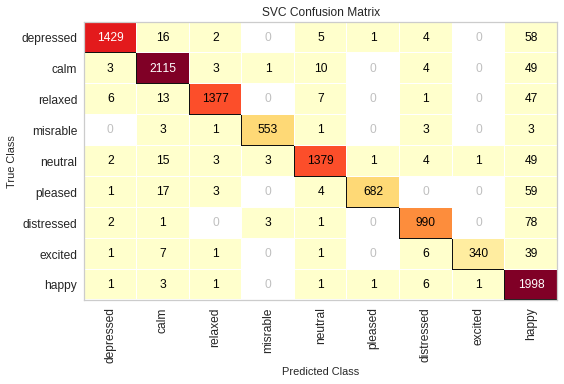

In [ ]:
from yellowbrick.classifier import ConfusionMatrix
svm_cm = ConfusionMatrix(
    c, classes=classes,
    
)

svm_cm.fit(x_train, y_train)
svm_cm.score(x_test, y_test)
svm_cm.show()

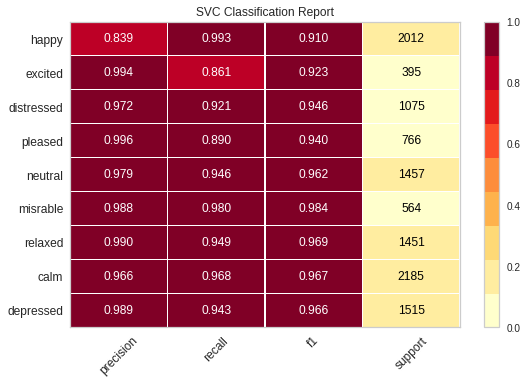

In [ ]:
from yellowbrick.classifier import ClassificationReport

visualizer = ClassificationReport(c, classes=classes, support=True)

visualizer.fit(x_train, y_train)       
visualizer.score(x_test, y_test)        
visualizer.show() 

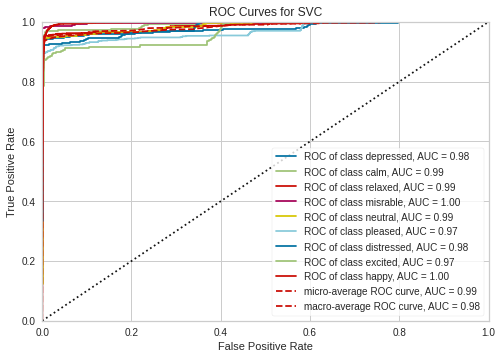

In [ ]:
from yellowbrick.classifier import ROCAUC
visualizer = ROCAUC(c, classes=classes)

visualizer.fit(x_train, y_train)        
visualizer.score(x_test, y_test)       
visualizer.show()     

In [ ]:
from sklearn.metrics import accuracy_score
pred_accu = accuracy_score(y_test,pred)
pred_accu

0.8106315154648057

In [ ]:
x_test.shape

(11724, 56)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators = 400) 
clf.fit(x_train, y_train)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators = 500) 
clf.fit(x_train, y_train)

RandomForestClassifier(n_estimators=500)

In [ ]:
y_pred = clf.predict(x_test)

In [ ]:
from sklearn import metrics 

In [ ]:
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))

ACCURACY OF THE MODEL:  0.750933659265295


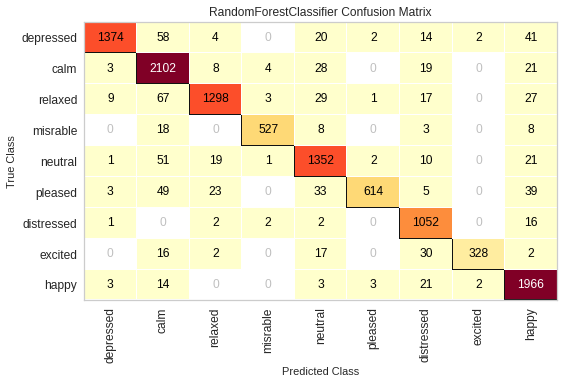

In [ ]:
from yellowbrick.classifier import ConfusionMatrix
random_forest_cm = ConfusionMatrix(
    clf, classes=classes,
    
)

random_forest_cm.fit(x_train, y_train)
random_forest_cm.score(x_test, y_test)
random_forest_cm.show()

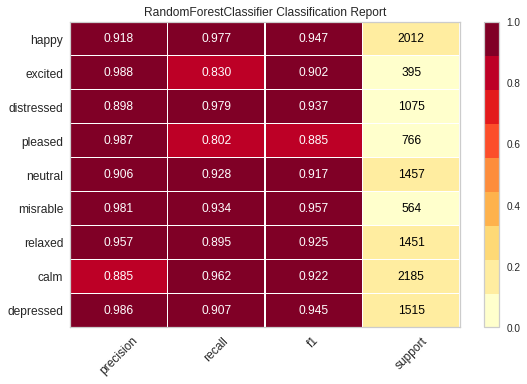

In [ ]:
from yellowbrick.classifier import ClassificationReport
classes=['depressed','calm','relaxed','misrable','neutral','pleased','distressed','excited','happy']
visualizer = ClassificationReport(clf, classes=classes, support=True)

visualizer.fit(x_train, y_train)       
visualizer.score(x_test, y_test)       
visualizer.show() 

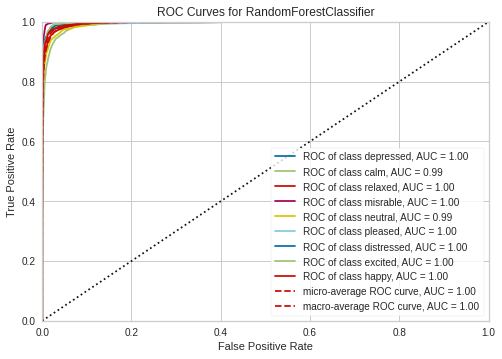

In [ ]:
from yellowbrick.classifier import ROCAUC
visualizer = ROCAUC(clf, classes=classes)

visualizer.fit(x_train, y_train)       
visualizer.score(x_test, y_test)       
visualizer.show()     

In [ ]:
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))

ACCURACY OF THE MODEL:  0.7214611872146118


In [ ]:
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))

ACCURACY OF THE MODEL:  0.9136191677175284


In [ ]:

# Import necessary modules
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
 
knn.fit(x_train, y_train)

y_pred=knn.predict(x_test)
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))

ACCURACY OF THE MODEL:  0.7233652475045834


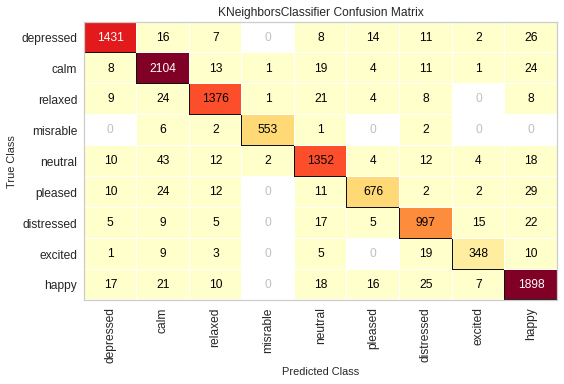

In [ ]:
from yellowbrick.classifier import ConfusionMatrix
knn_cm = ConfusionMatrix(
    knn, classes=classes,
    
)

knn_cm.fit(x_train, y_train)
knn_cm.score(x_test, y_test)
knn_cm.show()

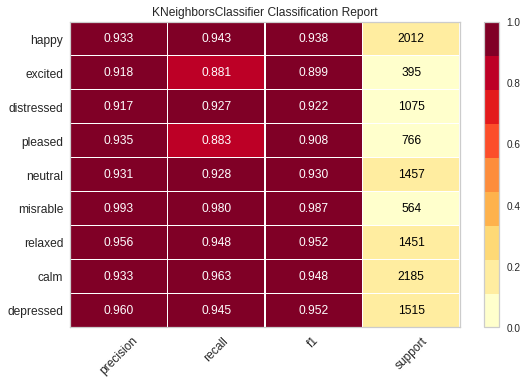

In [ ]:
from yellowbrick.classifier import ClassificationReport

visualizer = ClassificationReport(knn, classes=classes, support=True)

visualizer.fit(x_train, y_train)       
visualizer.score(x_test, y_test)       
visualizer.show() 

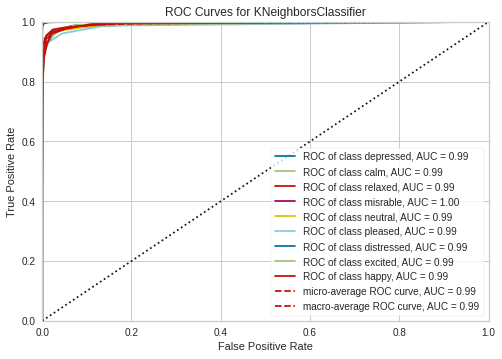

In [ ]:
from yellowbrick.classifier import ROCAUC
visualizer = ROCAUC(knn, classes=classes)

visualizer.fit(x_train, y_train)        
visualizer.score(x_test, y_test)       
visualizer.show()         

In [ ]:
from sklearn import svm
c = svm.SVC(kernel='rbf',C=10,gamma=0.1)
c.fit(x_train,y_train)
y_pred = c.predict(x_test)
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))

ACCURACY OF THE MODEL:  0.8031506756297956


In [ ]:
from sklearn import svm
c = svm.SVC(kernel='rbf')
c.fit(X_train_2,y_train)
y_pred = c.predict(X_test_2)
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))

ACCURACY OF THE MODEL:  0.4759002381953202


In [ ]:
import numpy as np
from sklearn.preprocessing import normalize
import pickle as pickle
import matplotlib.pyplot as plt
import pandas as pd
# import pyeeg as pe
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM,BatchNormalization,Activation
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM,BatchNormalization,Activation
import tensorflow

In [ ]:
res = []

In [ ]:
for i in range(1,33):
  if i <10:
    i = '0'+str(i)
  else:
    i = str(i)
  subjectList = [i]
  print(subjectList)
  data, label = load_data(subjectList)
  df_emo = one_hot_encoding(label)
  # n_e = len(df_emo.loc[:,0].unique())
  # print(n_e)
  x = data
  y = df_emo.loc[:,0]
  scaler = StandardScaler()
  x = scaler.fit_transform(x)
  x = np.reshape(x, (x.shape[0],1,x.shape[1]))
  y = to_categorical(y)
  n_e = y.shape[-1]
  x_train1, x_test1, y_train1, y_test1 = train_test_split(x, y, test_size = 0.2, random_state = 4)
  model1 = model(n_e)
  history1 = model1.fit(x_train1, y_train1, verbose=0,epochs = 100, batch_size=100,validation_data= (x_test1, y_test1))
  r = [i,history1.history['accuracy'][-1],history1.history['val_accuracy'][-1]]
  print(r)
  res.append(r)

['01']


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


['01', 0.9872317314147949, 0.9858849048614502]
['02']


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


['02', 0.9644118547439575, 0.9467969536781311]
['03']


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


['03', 0.97555011510849, 0.9652551412582397]
['04']


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


['04', 0.9478402733802795, 0.9565689563751221]
['05']


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


['05', 0.9443086385726929, 0.9142236709594727]
['06']


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


['06', 0.9760934710502625, 0.9587404727935791]
['07']


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


['07', 0.9875034093856812, 0.9837133288383484]
['08']


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


['08', 0.9657701849937439, 0.9609120488166809]
['09']


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


['09', 0.9842433929443359, 0.9728555679321289]
['10']


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


['10', 0.9587068557739258, 0.9261671900749207]
['11']


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


['11', 0.9562618732452393, 0.9402822852134705]
['12']


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


['12', 0.954088568687439, 0.9131379127502441]
['13']


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


['13', 0.9576202034950256, 0.9218240976333618]
['14']


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


['14', 0.9513719081878662, 0.9381107687950134]
['15']


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


['15', 0.9823417663574219, 0.9891422390937805]
['16']


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


['16', 0.9763650894165039, 0.9728555679321289]
['17']


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


['17', 0.9652268290519714, 0.9359391927719116]
['18']


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


['18', 0.9793534278869629, 0.9511400461196899]
['19']


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


['19', 0.9687584638595581, 0.9587404727935791]
['20']


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


['20', 0.9703884720802307, 0.9348534345626831]
['21']


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


['21', 0.9652268290519714, 0.9435396194458008]
['22']


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


['22', 0.9195870757102966, 0.9001085758209229]
['23']


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


['23', 0.9837000966072083, 0.9891422390937805]
['24']


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


['24', 0.9690301418304443, 0.9576547145843506]
['25']


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


['25', 0.9597935080528259, 0.9500542879104614]
['26']


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


['26', 0.9671285152435303, 0.9446253776550293]
['27']


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


['27', 0.9744634628295898, 0.9739413857460022]
['28']


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


['28', 0.9578918814659119, 0.9424538612365723]
['29']


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


['29', 0.9826134443283081, 0.9706840515136719]
['30']


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


['30', 0.9739201068878174, 0.9706840515136719]
['31']


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


['31', 0.9744634628295898, 0.9500542879104614]
['32']


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


['32', 0.9820700883865356, 0.9858849048614502]


In [ ]:
df = pd.DataFrame(res,columns=['Subject','Accuracy','Val Accuracy'])

In [ ]:
df.to_csv('/content/drive/My Drive/data_preprocessed_python/dwt_lstm_Results.csv')

In [ ]:
x = np.reshape(x, (x.shape[0],1,x.shape[1]))

In [ ]:
y = df_emo.loc[:,0]
y = to_categorical(y)

In [ ]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(x, y, test_size = 0.2, random_state = 4)

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(46425, 140)
(46425,)
(11607, 140)
(11607,)


In [ ]:

model = Sequential()
model.add(LSTM(512, batch_input_shape = (None, None, x.shape[2]),return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.3))


model.add(LSTM(256,activation="relu",return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.5))


model.add(LSTM(128,activation="relu",return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(LSTM(64,activation="relu",return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.3))


model.add(LSTM(32,activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.2))


model.add(Dense(9))
model.add(Activation('softmax'))



rmsprop =tensorflow.keras.optimizers.RMSprop(lr=0.0005, rho=0.9, epsilon=1e-08)
model.compile(loss='mean_squared_error',
                  optimizer=rmsprop,
                  metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, None, 512)         1337344   
                                                                 
 batch_normalization_5 (Batc  (None, None, 512)        2048      
 hNormalization)                                                 
                                                                 
 dropout_5 (Dropout)         (None, None, 512)         0         
                                                                 
 lstm_6 (LSTM)               (None, None, 256)         787456    
                                                                 
 batch_normalization_6 (Batc  (None, None, 256)        1024      
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, None, 256)        

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
history = model.fit(x_train1, y_train1, epochs = 500, batch_size=150,validation_data= (x_test1, y_test1))

Epoch 1/500
99/99 [==============================] - 10s 33ms/step - loss: 0.1052 - accuracy: 0.1681 - val_loss: 0.0980 - val_accuracy: 0.1483
Epoch 2/500
99/99 [==============================] - 2s 23ms/step - loss: 0.1000 - accuracy: 0.2221 - val_loss: 0.0978 - val_accuracy: 0.1418
Epoch 3/500
99/99 [==============================] - 2s 23ms/step - loss: 0.0981 - accuracy: 0.2435 - val_loss: 0.0978 - val_accuracy: 0.1678
Epoch 4/500
99/99 [==============================] - 2s 23ms/step - loss: 0.0967 - accuracy: 0.2612 - val_loss: 0.0968 - val_accuracy: 0.2208
Epoch 5/500
99/99 [==============================] - 2s 22ms/step - loss: 0.0954 - accuracy: 0.2678 - val_loss: 0.0947 - val_accuracy: 0.2610
Epoch 6/500
99/99 [==============================] - 2s 23ms/step - loss: 0.0943 - accuracy: 0.2798 - val_loss: 0.0940 - val_accuracy: 0.2466
Epoch 7/500
99/99 [==============================] - 2s 23ms/step - loss: 0.0931 - accuracy: 0.2892 - val_loss: 0.0926 - val_accuracy: 0.2743
Epoch

In [ ]:
def model(n_e):
  model1 = Sequential()
  model1.add(LSTM(512, batch_input_shape = (None, None, x.shape[2]),return_sequences=True))
  model1.add(BatchNormalization())
  model1.add(Dropout(0.3))


  model1.add(LSTM(256,activation="tanh",return_sequences=True))
  model1.add(BatchNormalization())
  model1.add(Dropout(0.5))


  model1.add(LSTM(128,activation="tanh",return_sequences=True))
  model1.add(BatchNormalization())
  model1.add(Dropout(0.3))

  model1.add(LSTM(64,activation="tanh",return_sequences=True))
  model1.add(BatchNormalization())
  model1.add(Dropout(0.3))


  model1.add(LSTM(32,activation="tanh"))
  model1.add(BatchNormalization())
  model1.add(Dropout(0.2))


  model1.add(Dense(n_e))
  model1.add(Activation('softmax'))



  rmsprop =tensorflow.keras.optimizers.RMSprop(learning_rate=0.0005, rho=0.9, epsilon=1e-08)
  model1.compile(loss='mean_squared_error',
                    optimizer=rmsprop,
                    metrics=['accuracy'])
  # model1.summary()
  return model1

In [ ]:
history1 = model1.fit(x_train1, y_train1, epochs = 500, batch_size=150,validation_data= (x_test1, y_test1))

Epoch 1/500
310/310 [==============================] - 19s 21ms/step - loss: 0.0989 - accuracy: 0.2417 - val_loss: 0.0894 - val_accuracy: 0.3218
Epoch 2/500
310/310 [==============================] - 5s 16ms/step - loss: 0.0899 - accuracy: 0.3158 - val_loss: 0.0832 - val_accuracy: 0.3861
Epoch 3/500
310/310 [==============================] - 5s 16ms/step - loss: 0.0860 - accuracy: 0.3557 - val_loss: 0.0812 - val_accuracy: 0.4015
Epoch 4/500
310/310 [==============================] - 5s 16ms/step - loss: 0.0838 - accuracy: 0.3814 - val_loss: 0.0810 - val_accuracy: 0.4085
Epoch 5/500
310/310 [==============================] - 5s 17ms/step - loss: 0.0820 - accuracy: 0.3977 - val_loss: 0.0791 - val_accuracy: 0.4263
Epoch 6/500
310/310 [==============================] - 5s 16ms/step - loss: 0.0810 - accuracy: 0.4075 - val_loss: 0.0784 - val_accuracy: 0.4419
Epoch 7/500
310/310 [==============================] - 5s 16ms/step - loss: 0.0795 - accuracy: 0.4196 - val_loss: 0.0763 - val_accuracy